## connect economic data

##### imports

In [4]:
import pandas as pd
from helpers import get_next_filename 
from matplotlib import pyplot as plt
import pandasql as ps

#### variables

In [5]:
input_path = "filtered_dataset/filtered_dataset_1.csv"
output_folder = "connnected_economic_data" 

#### main function

In [ ]:
output_path = get_next_filename("connnected_economic_data", output_folder)

df = pd.read_csv(input_path, low_memory=False)

# Обчислення середньої зарплати для кожної категорії
result = df.groupby(['period', 'final_seniority'])['final_salary'].mean().reset_index()

# Перейменування колонки для середньої зарплати
result.rename(columns={'final_salary': 'average_salary'}, inplace=True)

# Завантаження другого датасету (індекс споживчих цін)
yearly_data = pd.read_csv("economical_data/індекс_споживчих_цін.csv", low_memory=False, delimiter=';')

# Ділення значень індексу споживчих цін на 100
columns_to_divide = ['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December']
yearly_data[columns_to_divide] = yearly_data[columns_to_divide] / 100

# Обчислення добутків для H1 (січень-червень) і H2 (липень-грудень)
yearly_data['H1'] = yearly_data[['January', 'February', 'March', 'April', 'May', 'June']].prod(axis=1)
yearly_data['H2'] = yearly_data[['July', 'August', 'September', 'October', 'November', 'December']].prod(axis=1)

# Перетворення у формат для приєднання
yearly_data_long = yearly_data.melt(id_vars=['Year'], value_vars=['H1', 'H2'], var_name='Half', value_name='consumer price index')
yearly_data_long['period'] = yearly_data_long['Year'].astype(str) + '_' + yearly_data_long['Half']

# Приєднання до основного датасету
merged_data = pd.merge(result, yearly_data_long[['period', 'consumer price index']], on='period', how='left')

# Завантаження даних про дохід населення
income_data = pd.read_csv("economical_data/дохід_населення.csv", delimiter=';')

# Дублювання даних про дохід населення для кожного півріччя
income_data_long = income_data.loc[income_data.index.repeat(2)].reset_index(drop=True)
income_data_long['Half'] = ['H1', 'H2'] * (len(income_data))
income_data_long['period'] = income_data_long['Year'].astype(str) + '_' + income_data_long['Half']

# Додавання колонки "income of the population"
income_data_long = income_data_long.rename(columns={'Disposable income per capita, UAH': 'income of the population'})

# Приєднання даних про дохід населення до основного датасету
merged_data = pd.merge(merged_data, income_data_long[['period', 'income of the population']], on='period', how='left')

# Завантаження даних про ВВП
gdp_data = pd.read_csv("economical_data/ввп.csv", delimiter=';')

# Видалення зайвих пробілів у назвах колонок
gdp_data.columns = gdp_data.columns.str.strip()

# Дублювання даних про ВВП для кожного півріччя
gdp_data_long = gdp_data.loc[gdp_data.index.repeat(2)].reset_index(drop=True)
gdp_data_long['Half'] = ['H1', 'H2'] * (len(gdp_data))
gdp_data_long['period'] = gdp_data_long['Year'].astype(str) + '_' + gdp_data_long['Half']

# Додавання колонок про ВВП
gdp_data_long = gdp_data_long.rename(columns={
    'Gross regional product (mln UAH)': 'gross regional product',
    'Volume indices of gross regional product (percent)': 'volume indices of gross regional product',
    'Per capita gross regional product (UAH)': 'per capita gross regional product'
})


# Приєднання даних про ВВП до основного датасету
final_data = pd.merge(merged_data, gdp_data_long[['period', 'gross regional product', 'volume indices of gross regional product', 'per capita gross regional product']], on='period', how='left')
# Завантаження даних про пошукові запити
google_search_data = pd.read_csv("economical_data/google_search_in_ukraine.csv", delimiter=',')

# Перейменування колонок для зручності
google_search_data.columns = ['Month', 'search_count']

# Перетворення колонки "Month" на формат datetime
google_search_data['Month'] = pd.to_datetime(google_search_data['Month'], format='%Y-%m')

# Додавання колонок "Year" і "Half" (півріччя)
google_search_data['Year'] = google_search_data['Month'].dt.year
google_search_data['Half'] = google_search_data['Month'].dt.month.apply(lambda x: 'H1' if x <= 6 else 'H2')

# Групування даних за роком і півріччям, обчислення суми пошуків
google_search_data_grouped = google_search_data.groupby(['Year', 'Half'])['search_count'].sum().reset_index()

# Створення колонки "period" у форматі YYYY_H1 або YYYY_H2
google_search_data_grouped['period'] = google_search_data_grouped['Year'].astype(str) + '_' + google_search_data_grouped['Half']

# Додавання колонки google_search_for_data_science
google_search_data_grouped = google_search_data_grouped.rename(columns={'search_count': 'google_search_for_data_science'})

# Приєднання даних про пошукові запити до основного датасету
final_data = pd.merge(final_data, google_search_data_grouped[['period', 'google_search_for_data_science']], on='period', how='left')

# Завантаження даних про споживчі витрати
expenditure_data = pd.read_csv("economical_data/dataset_2025-05-10T16_10_45.267670971Z_DEFAULT_INTEGRATION_IMF.STA_QNEA_7.0.0.csv")

# Перевіримо структуру даних
print("Перші кілька рядків даних:")
print(expenditure_data.head())

# Фільтруємо дані для країни "Ukraine" та показника "Final consumption expenditure"
expenditure_data = expenditure_data[(expenditure_data['COUNTRY'] == 'Ukraine') & 
                                     (expenditure_data['INDICATOR'] == 'Final consumption expenditure')]

# Перетворення TIME_PERIOD на формат року і кварталу
expenditure_data[['Year', 'Quarter']] = expenditure_data['TIME_PERIOD'].str.split('-Q', expand=True)

# Видалення рядків з NaN у колонках Year та Quarter
expenditure_data = expenditure_data.dropna(subset=['Year', 'Quarter'])

# Перетворення колонок Year та Quarter на тип int
expenditure_data['Year'] = expenditure_data['Year'].astype(int)
expenditure_data['Quarter'] = expenditure_data['Quarter'].astype(int)

# Додавання колонки "Half" (півріччя)
expenditure_data['Half'] = expenditure_data['Quarter'].apply(lambda x: 'H1' if x <= 2 else 'H2')

# Групування даних за роком і півріччям, обчислення суми витрат
expenditure_data_grouped = expenditure_data.groupby(['Year', 'Half'])['OBS_VALUE'].sum().reset_index()

# Створення колонки "period" у форматі YYYY_H1 або YYYY_H2
expenditure_data_grouped['period'] = expenditure_data_grouped['Year'].astype(str) + '_' + expenditure_data_grouped['Half']

# Додавання колонки про споживчі витрати
expenditure_data_grouped = expenditure_data_grouped.rename(columns={'OBS_VALUE': 'final_consumption_expenditure'})

# Приєднання даних про споживчі витрати до основного датасету
final_data = pd.merge(final_data, expenditure_data_grouped[['period', 'final_consumption_expenditure']], on='period', how='left')

# Витягуємо рік із колонки "period" і додаємо як окрему колонку
final_data['Year'] = final_data['period'].str.extract(r'(\d{4})').astype(int)

# Фільтруємо дані, залишаючи лише рядки, де рік менший за 2021
filtered_data = final_data[final_data['Year'] < 2021]

# Видаляємо допоміжну колонку "Year", якщо вона більше не потрібна
filtered_data = filtered_data.drop(columns=['Year'])

# Збереження результату у новий CSV-файл
filtered_data.to_csv(output_path, index=False)



Перші кілька рядків даних:
   COUNTRY                      INDICATOR       PRICE_TYPE  \
0  Ukraine  Final consumption expenditure  Constant prices   
1  Ukraine  Final consumption expenditure  Constant prices   
2  Ukraine  Final consumption expenditure  Constant prices   
3  Ukraine  Final consumption expenditure  Constant prices   
4  Ukraine  Final consumption expenditure  Constant prices   

               S_ADJUSTMENT TYPE_OF_TRANSFORMATION  FREQUENCY TIME_PERIOD  \
0  Seasonally adjusted (SA)      Domestic currency  Quarterly     2016-Q1   
1  Seasonally adjusted (SA)      Domestic currency  Quarterly     2016-Q2   
2  Seasonally adjusted (SA)      Domestic currency  Quarterly     2016-Q3   
3  Seasonally adjusted (SA)      Domestic currency  Quarterly     2016-Q4   
4  Seasonally adjusted (SA)      Domestic currency  Quarterly     2017-Q1   

      OBS_VALUE  SCALE  
0  5.036320e+11    NaN  
1  5.005890e+11    NaN  
2  5.109330e+11    NaN  
3  5.171740e+11    NaN  
4  5.415790e

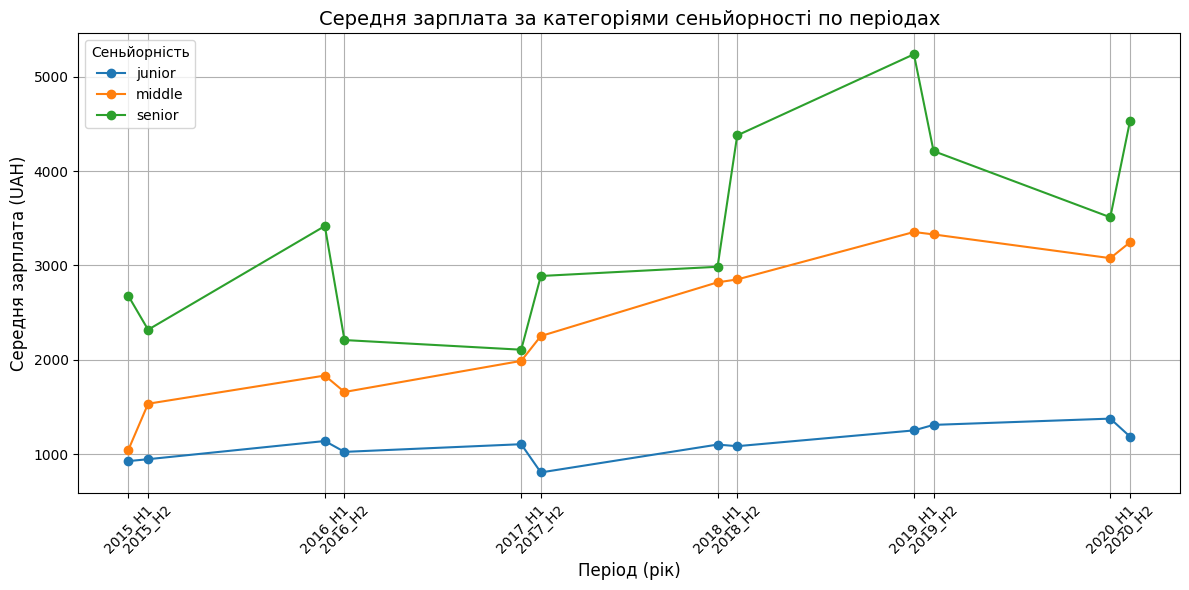

In [7]:
data = pd.read_csv(output_path, low_memory=False)
# Перетворення періоду на числовий формат для коректного сортування
data['period_numeric'] = data['period'].str.replace('_H1', '.1').str.replace('_H2', '.2').astype(float)

# Побудова графіків
plt.figure(figsize=(12, 6))

# Фільтрування даних для кожної категорії сеньйорності
for seniority in ['junior', 'middle', 'senior']:
    subset = data[data['final_seniority'] == seniority]
    plt.plot(subset['period_numeric'], subset['average_salary'], marker='o', label=seniority)

# Налаштування графіка
plt.title('Середня зарплата за категоріями сеньйорності по періодах', fontsize=14)
plt.xlabel('Період (рік)', fontsize=12)
plt.ylabel('Середня зарплата (UAH)', fontsize=12)
plt.xticks(data['period_numeric'].unique(), data['period'].unique(), rotation=45)
plt.legend(title='Сеньйорність')
plt.grid(True)

# Показати графік
plt.tight_layout()
plt.show()

In [8]:
data = pd.read_csv("raw_salary_compile/combined_salary_1.csv", low_memory=False)
query = """
    SELECT max(salary) 
    from data
    where period = '2021_H1' and seniority = 'Junior'
"""

# Виконання запиту
unique_bonuses_flag = ps.sqldf(query, locals())

# Виведення результату
print(unique_bonuses_flag)

  max(salary)
0         960
